### Here, I will train an Isolation Forest model on the million transaction dataset

In [2]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sys
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# SCRIPTS
sys.path.append(os.path.abspath(".."))
from scripts import conversions
from scripts import isolation_forest

In [3]:
isolation_df = pd.read_csv('../data/full_transactions.csv')
isolation_df

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,223837,180.411926,2025-02-14 10:16:10,-0.011788
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.000000,153985,81.237520,2025-02-14 10:16:10,-0.011788
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.000000,223550,65.091946,2025-02-14 10:16:11,-0.011788
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.000000,500002,63.063619,2025-02-14 10:16:11,-0.011788
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,252997,47.995919,2025-02-14 10:16:11,-0.011788
...,...,...,...,...,...,...,...,...
1000460,0x8cbf01dc0bbebe854a64ccd7e9ccee8876c95ee30cfb...,0x5698D4ec03802438Bce268b02eb3817B8C3C2b3f,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0.000000,45758,1.919426,2025-02-17 06:06:35,-0.011788
1000461,0xb0fac9da7e21836663a05e8bcfd429a64e66160f10d7...,0x5baBE600b9fCD5fB7b66c0611bF4896D967b23A1,0xf45AFF520a8Ebe59f513719fc78b164e375Dd1f4,0.007562,21000,1.917395,2025-02-17 06:06:35,-0.011718
1000462,0x488d4e454120b061f3a0c41008b90d1156737845d91a...,0x99719eacc100BD48D4dbEb96E990333a7601e5B8,0x65c55F33F9493E8702FEea89B4fA357283eD3841,0.000000,302687,1.917395,2025-02-17 06:06:35,-0.011788
1000463,0xcdda18972b9baf4310ce4be72d1ec91dc32bb2f02c6b...,0x6a0913BA185848c09250D3F40DFf29dC45530978,0xb965602E41Af7A92B3F4b48729736Aded9C94E47,0.000000,500000,1.913384,2025-02-17 06:06:35,-0.011788


### Training on all different feature subsets of data. We want 1% of transactions to be flagged as suspicious.

Number of anomalies flagged: 9892
Number of unflagged points: 990573


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


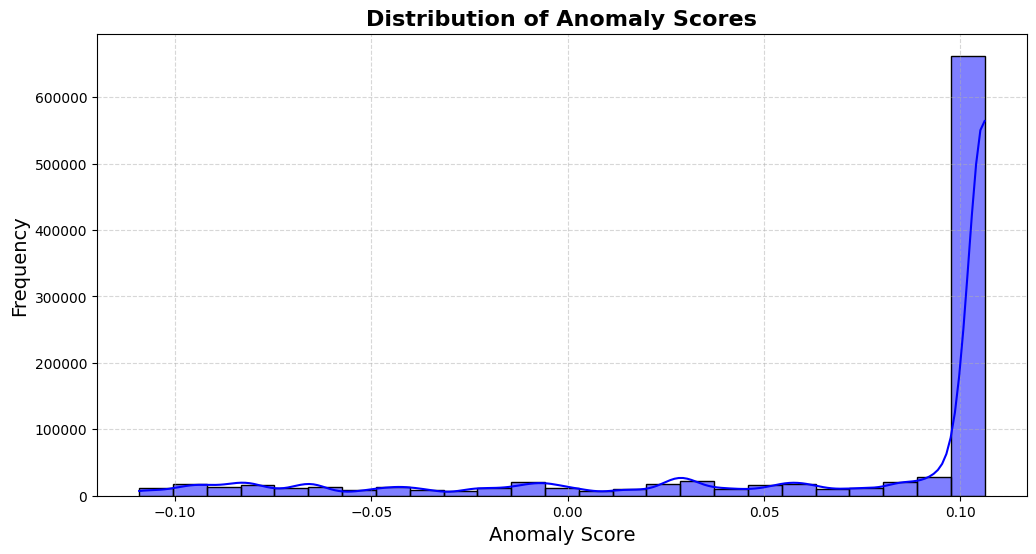

Min: -0.10917410355666701
Max: 0.10621677975198196
Mean: 0.07038703375812863
Std Dev: 0.06184142395314464


In [ ]:
features_1 = ['value']
features_2 = ['value', 'gas_price']
features_3 = ['value']
features_4 = []
features_5 = []

df_results_value = isolation_forest.train_isolation_forest(isolation_df, ['value'], 100, .01)




In [ ]:
df_results

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore,anomaly_score
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,223837,180.411926,2025-02-14 10:16:10,-0.011788,1
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.000000,153985,81.237520,2025-02-14 10:16:10,-0.011788,1
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.000000,223550,65.091946,2025-02-14 10:16:11,-0.011788,1
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.000000,500002,63.063619,2025-02-14 10:16:11,-0.011788,1
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,252997,47.995919,2025-02-14 10:16:11,-0.011788,1
...,...,...,...,...,...,...,...,...,...
1000460,0x8cbf01dc0bbebe854a64ccd7e9ccee8876c95ee30cfb...,0x5698D4ec03802438Bce268b02eb3817B8C3C2b3f,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0.000000,45758,1.919426,2025-02-17 06:06:35,-0.011788,1
1000461,0xb0fac9da7e21836663a05e8bcfd429a64e66160f10d7...,0x5baBE600b9fCD5fB7b66c0611bF4896D967b23A1,0xf45AFF520a8Ebe59f513719fc78b164e375Dd1f4,0.007562,21000,1.917395,2025-02-17 06:06:35,-0.011718,1
1000462,0x488d4e454120b061f3a0c41008b90d1156737845d91a...,0x99719eacc100BD48D4dbEb96E990333a7601e5B8,0x65c55F33F9493E8702FEea89B4fA357283eD3841,0.000000,302687,1.917395,2025-02-17 06:06:35,-0.011788,1
1000463,0xcdda18972b9baf4310ce4be72d1ec91dc32bb2f02c6b...,0x6a0913BA185848c09250D3F40DFf29dC45530978,0xb965602E41Af7A92B3F4b48729736Aded9C94E47,0.000000,500000,1.913384,2025-02-17 06:06:35,-0.011788,1


128           8.200000
278          32.000000
351           8.000000
375           9.350000
393           5.875345
              ...     
999900       10.657731
1000147       4.900000
1000195       5.172023
1000363      31.716546
1000441    2796.000000
Name: value, Length: 9892, dtype: float64


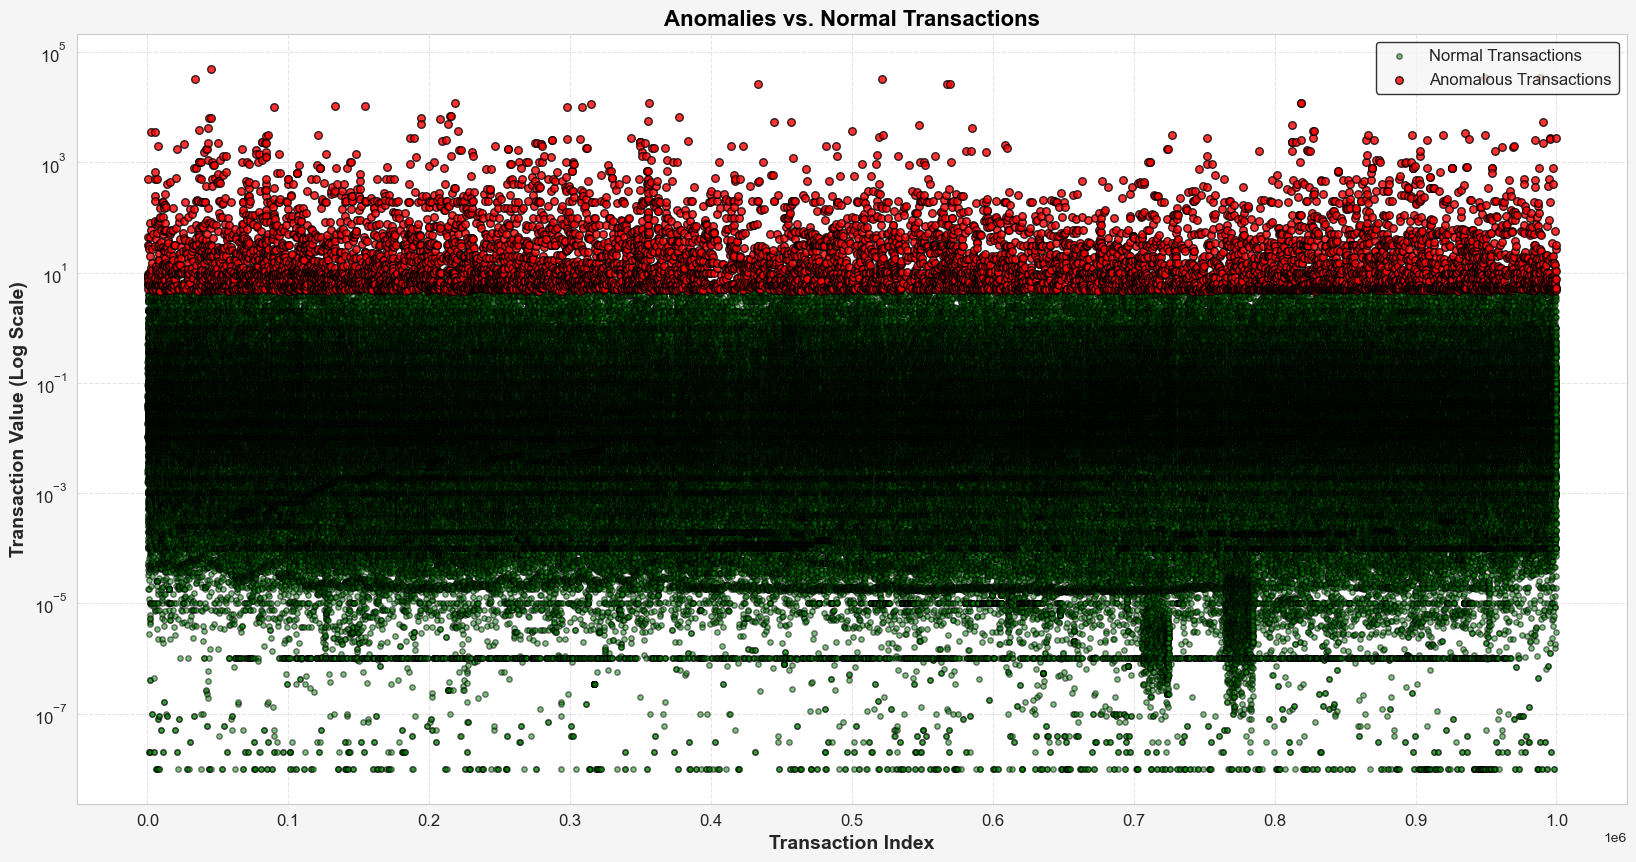

In [ ]:
isolation_forest.scatter_plot_anomalies(df_results)